In [1]:
! export CUDA_LAUNCH_BLOCKING=1

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
import torch
import logging
import os
import h5py
import numpy as np
import pandas as pd
import random
from torch import nn
import torchvision
import torch.nn.functional as F
from datetime import datetime

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

logger = logging.getLogger(__name__)
if logger.handlers:
    logger.handlers = []
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())        

In [4]:
device = torch.device('cuda')
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='TITAN Xp', major=6, minor=1, total_memory=12196MB, multi_processor_count=30)

In [5]:
def seed_everything(seed=10):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [6]:
def median_smoothing(signal, width=3):
    s = signal[:]
    half_width = int(width/2)
    for i in range(half_width, len(signal)):
        s[i-half_width] = torch.median(signal[i-half_width:i+half_width])
    return s

In [7]:
class MolbitDataset(Dataset):
    def __init__(self, data_file):
        with h5py.File(data_file, "r") as f:
            self.data = torch.FloatTensor(f.get("data")[()])
            self.labels = torch.IntTensor(f.get("labels")[()])
        
        self.n_records = len(self.labels)
        self.max_len = self.data.shape[2]
        self.n_labels = len(np.unique(self.labels))

        # Shuffle data
        self.shuffle_index = np.random.choice(range(self.n_records), replace=False, size=self.n_records)
        self.data = self.data[self.shuffle_index]       
        self.labels = self.labels[self.shuffle_index]        
        
    def _get_onehot(self, label):
        ix = self.labels.index(label)
        onehot = torch.zeros(self.n_labels)
        onehot[ix] = 1
        return onehot
    
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        return self.data[idx, :, :], self.labels[idx]

In [8]:
molbit_data_file = "/path/to/data/v4_train/20190822_train.hdf5"

In [9]:
md = MolbitDataset(molbit_data_file)

In [13]:
md.n_records

274667

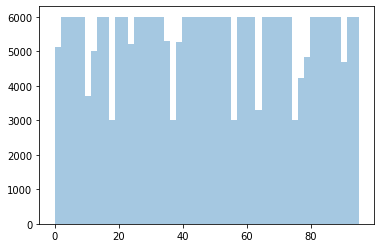

In [11]:
sns.distplot(md.labels, kde=False)

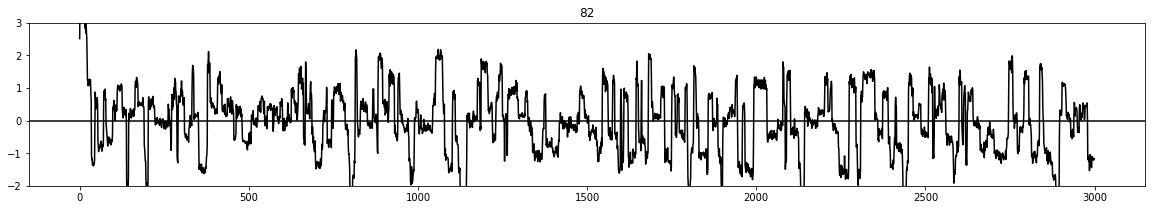

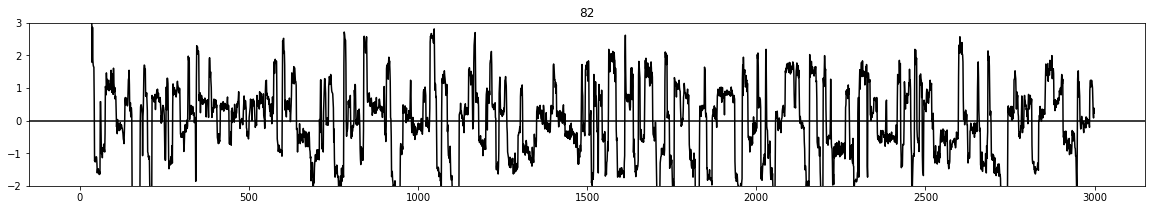

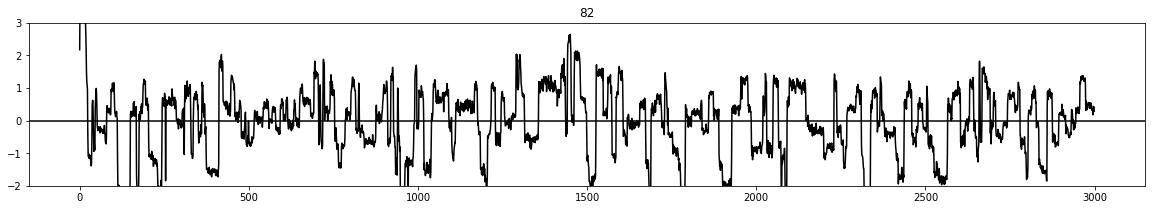

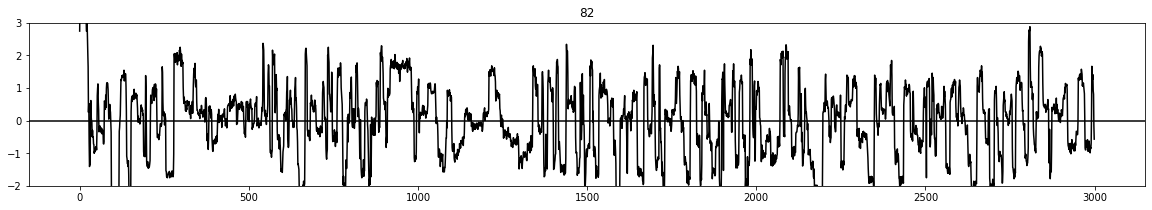

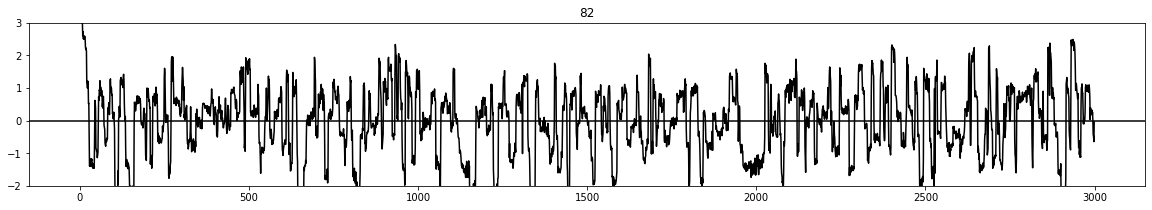

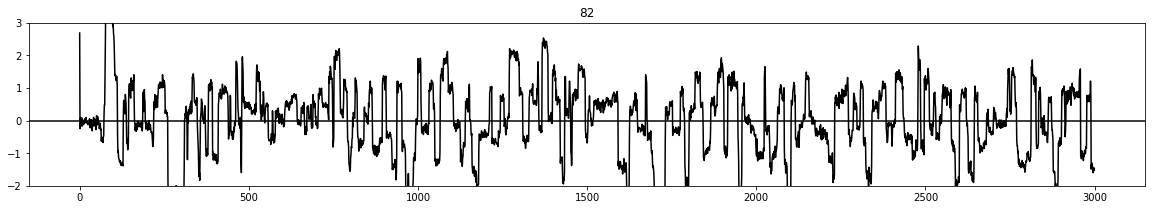

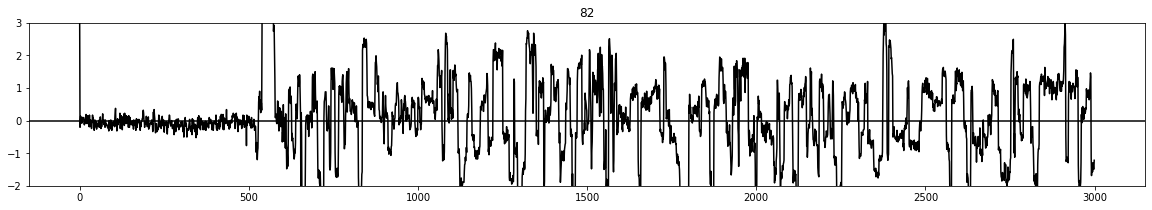

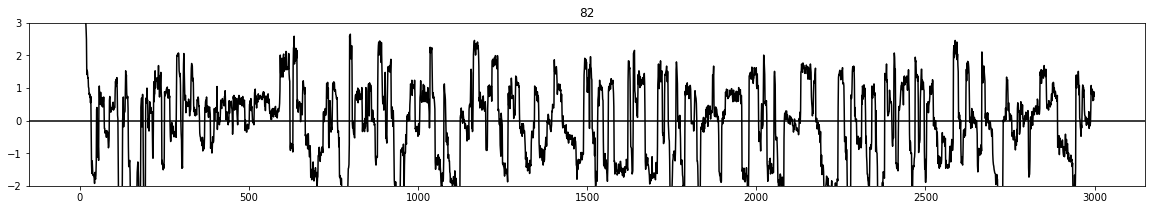

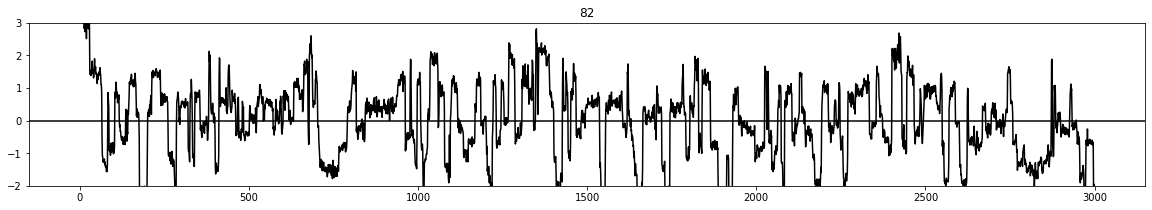

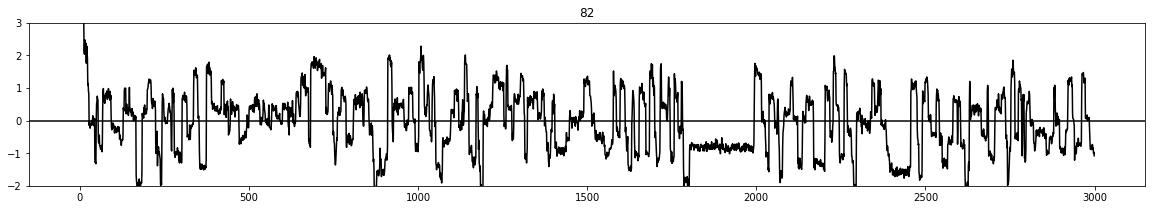

In [10]:
molbit = 82
max_len = 3000

ixs_of_molbit = np.where(md.labels == molbit)[0]
for ix in ixs_of_molbit[:10]:
    data, label = md[ix]
    fig, ax = plt.subplots(figsize=(20, 3))
    
    data = median_smoothing(data, width=5)
    ax.plot(range(max_len), np.array(data.squeeze()[:max_len]), c="k")
    ax.set_title(str(molbit))
    ax.set_ylim([-2, 3])
    ax.axhline(0, c="k")
    plt.show()

In [11]:
sum(md.labels == 82)

tensor(184, dtype=torch.uint8)

In [10]:
class CNN(nn.Module):

    def __init__(self):

        super(CNN, self).__init__()

        O_1 = 64
        O_2 = 128
        O_3 = 256
        O_4 = 512
        O_5 = 1024

        K_1 = 15
        K_2 = 8
        K_3 = 6
        K_4 = 4
        K_5 = 2

        KP_1 = 6
        KP_2 = 3
        KP_3 = 2
        KP_4 = 2
        KP_5 = 1

        FN_1 = 1000
        FN_2 = 500

        self.conv1 = nn.Sequential(nn.Conv1d(1, O_1, K_1, stride=1), nn.ReLU(),
                                   nn.AvgPool1d(KP_1))
        self.conv1_bn = nn.BatchNorm1d(O_1)

        self.conv2 = nn.Sequential(nn.Conv1d(O_1, O_2, K_2), nn.ReLU(),
                                   nn.AvgPool1d(KP_2))
        self.conv2_bn = nn.BatchNorm1d(O_2)

        self.conv3 = nn.Sequential(nn.Conv1d(O_2, O_3, K_3), nn.ReLU(),
                                   nn.AvgPool1d(KP_3))
        self.conv3_bn = nn.BatchNorm1d(O_3)

        self.conv4 = nn.Sequential(nn.Conv1d(O_3, O_4, K_4), nn.ReLU(),
                                   nn.AvgPool1d(KP_4))
        self.conv4_bn = nn.BatchNorm1d(O_4)

        self.conv5 = nn.Sequential(nn.Conv1d(O_4, O_5, K_5), nn.ReLU(),
                                   nn.AvgPool1d(KP_5))
        self.conv5_bn = nn.BatchNorm1d(O_5)

        self.gru1 = nn.GRU(input_size=92160, hidden_size=10, num_layers=1)

#         self.fc1 = nn.Linear(conv_linear_out, FN_1, nn.Dropout(0.4))
        self.fc1 = nn.Linear(37888, FN_1, nn.Dropout(0.5)) # 37888 20480 28672 9216
        self.fc1_bn = nn.BatchNorm1d(FN_1)

        self.fc2 = nn.Linear(FN_1, FN_2, nn.Dropout(0.5))
        self.fc2_bn = nn.BatchNorm1d(FN_2)

        self.fc3 = nn.Linear(FN_2, 96)

    def forward(self, x):
        x = x.float()
#         print("a", np.shape(x))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv1_bn(x))
#         print("b", np.shape(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2_bn(x))
#         print("c", np.shape(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv3_bn(x))
#         print("d", np.shape(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.relu(self.conv4_bn(x))
        x = F.leaky_relu(self.conv5(x))
        x = F.relu(self.conv5_bn(x))
#         print("e", np.shape(x))
    #	  x = x.view(1, 1, -1)
    #	  x = self.gru1(x)
        x = x.view(len(x), -1)
#         print("f", np.shape(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc1_bn(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc2_bn(x))
#         print("g", np.shape(x))

        x = self.fc3(x)
#         print("h", np.shape(x))
        return x


net = CNN()

In [24]:
seed_everything()

n_labels = md.n_labels
model = CNN()
model.cuda()


loader_params = {"batch_size": 20,
          "shuffle": False,
          "num_workers": 20}
max_epochs = 200

# Datasets
n_samples = len(md)
all_ix = range(n_samples)
n_train = int(0.84*n_samples)
n_val = n_samples - n_train
train_ix = np.random.choice(all_ix, size=n_train)
val_ix = np.array(list(set(all_ix[:]) - set(train_ix)))
train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)
training_generator = DataLoader(md, sampler=train_sampler, **loader_params)
validation_generator = DataLoader(md, sampler=val_sampler, **loader_params)

In [39]:
optim_params = {"lr": 0.001,
                "momentum": 0.5}

optimizer = torch.optim.Adam(model.parameters())#, **optim_params)
loss_fn = torch.nn.CrossEntropyLoss()

train_losses = []
val_losses = []
train_accs = []
val_accs = []

val_delta = 0.01
patience = 30

max_val_acc = 0
last_val_change = 0

logger.log(10, "Starting")

for epoch in range(max_epochs):
    logger.log(10, "Epoch: %d" % epoch)
    if last_val_change >= patience:
        print("Patience ran out.")
        break

    train_total_samples = 0
    train_correct = 0
    val_total_samples = 0
    val_correct = 0
    
    logger.log(10, "Train")
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        logger.log(1, "Transferring data to GPU")
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)
        
#         print(local_batch.shape)
#         print(local_labels.shape)
        
        logger.log(1, "Run model")
        optimizer.zero_grad()
        y_pred_train = model(local_batch).to(dtype=torch.float64)
#         print(y_pred_train.shape)
        local_labels = local_labels.to(dtype=torch.long)
        _, ypred_max_ix = torch.max(y_pred_train, dim=1)
        
        logger.log(1, "Calculate loss")
        train_loss = loss_fn(y_pred_train, local_labels)
        logger.log(1, "Backprop")
        train_loss.backward()
        optimizer.step()

        train_total_samples += local_labels.size(0)
        train_correct += (local_labels == ypred_max_ix).sum().item()

    logger.log(10, "Val")
    # Validation
    with torch.no_grad():
        for local_batch, local_labels in validation_generator:
            # Transfer to GPU
            local_batch = local_batch.to(device)
            local_labels = local_labels.to(device)
            y_pred_val = model(local_batch).to(dtype=torch.float64)
            local_labels = local_labels.to(dtype=torch.long)
            
            _, ypred_max_ix = torch.max(y_pred_val, dim=1)

            val_loss = loss_fn(y_pred_val, local_labels)

            val_total_samples += local_labels.size(0)
            val_correct += (local_labels == ypred_max_ix).sum().item()

    train_acc = 100. * train_correct / train_total_samples
    val_acc = 100. * val_correct / val_total_samples
    print("%d: Train loss: %0.7f\tVal loss: %0.7f\tTrain acc: %2.5f%%\tVal acc: %2.5f%%"
          % (epoch, train_loss.item(), val_loss.item(), train_acc, val_acc))
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if val_acc - max_val_acc <= val_delta:
        last_val_change += 1
    else:
        last_val_change = 0
    max_val_acc = max(val_acc, max_val_acc)

Starting
Epoch: 0
Train
Val
Epoch: 1
Train


0: Train loss: 0.0126301	Val loss: 0.3024064	Train acc: 79.07940%	Val acc: 93.25063%


Val
Epoch: 2
Train


1: Train loss: 0.0051144	Val loss: 0.0660848	Train acc: 95.95657%	Val acc: 95.77226%


Val
Epoch: 3
Train


2: Train loss: 0.0415206	Val loss: 0.7115198	Train acc: 97.67857%	Val acc: 94.86228%


Val
Epoch: 4
Train


3: Train loss: 0.8538112	Val loss: 0.0107543	Train acc: 98.34995%	Val acc: 96.83489%


Val
Epoch: 5
Train


4: Train loss: 0.0808648	Val loss: 0.0657009	Train acc: 98.85359%	Val acc: 96.93946%


Val
Epoch: 6
Train


5: Train loss: 0.0002209	Val loss: 0.5530103	Train acc: 99.04863%	Val acc: 97.09548%


Val
Epoch: 7
Train


6: Train loss: 0.0020195	Val loss: 0.0000045	Train acc: 99.26361%	Val acc: 97.05922%


Val
Epoch: 8
Train


7: Train loss: 0.0010845	Val loss: 2.0071255	Train acc: 99.37197%	Val acc: 97.07356%


Val
Epoch: 9
Train


8: Train loss: 0.0003871	Val loss: 0.0000816	Train acc: 99.44045%	Val acc: 97.03308%


Val
Epoch: 10
Train


9: Train loss: 0.1926498	Val loss: 0.0130890	Train acc: 99.52020%	Val acc: 97.11404%


Val
Epoch: 11
Train


10: Train loss: 0.0035205	Val loss: 0.0184138	Train acc: 99.58781%	Val acc: 97.29536%


Val
Epoch: 12
Train


11: Train loss: 0.0012890	Val loss: 0.0029980	Train acc: 99.62682%	Val acc: 97.18404%


Val
Epoch: 13
Train


12: Train loss: 0.0006130	Val loss: 1.2612603	Train acc: 99.67493%	Val acc: 97.29705%


Val
Epoch: 14
Train


13: Train loss: 0.0000092	Val loss: 0.0000343	Train acc: 99.65976%	Val acc: 97.27090%


Val
Epoch: 15
Train


14: Train loss: 0.0041132	Val loss: 1.0049827	Train acc: 99.70397%	Val acc: 97.24645%


Val
Epoch: 16
Train


15: Train loss: 0.0000000	Val loss: 1.0938199	Train acc: 99.73648%	Val acc: 97.42186%


Val
Epoch: 17
Train


16: Train loss: 0.0000001	Val loss: 0.8489804	Train acc: 99.73994%	Val acc: 97.39994%


Val
Epoch: 18
Train


17: Train loss: 0.0000048	Val loss: 0.0018677	Train acc: 99.75295%	Val acc: 97.31138%


Val
Epoch: 19
Train


18: Train loss: 0.0004325	Val loss: 0.0000000	Train acc: 99.77462%	Val acc: 97.45054%


Val
Epoch: 20
Train


19: Train loss: 0.0000058	Val loss: 0.0000002	Train acc: 99.75902%	Val acc: 97.41512%


Val
Epoch: 21
Train


20: Train loss: 0.0000483	Val loss: 0.0007754	Train acc: 99.78936%	Val acc: 97.36789%


Val
Epoch: 22
Train


21: Train loss: 0.0005896	Val loss: 0.0434735	Train acc: 99.79586%	Val acc: 97.44969%


Val
Epoch: 23
Train


22: Train loss: 0.0000083	Val loss: 0.0000002	Train acc: 99.81189%	Val acc: 97.42861%


Val
Epoch: 24
Train


23: Train loss: 0.0014586	Val loss: 0.0000039	Train acc: 99.79716%	Val acc: 97.43536%


Val
Epoch: 25
Train


24: Train loss: 0.0000198	Val loss: 0.7342282	Train acc: 99.82403%	Val acc: 97.41427%


Val
Epoch: 26
Train


25: Train loss: 0.0000002	Val loss: 0.0000001	Train acc: 99.82533%	Val acc: 97.43873%


Val
Epoch: 27
Train


26: Train loss: 0.0009965	Val loss: 0.0074061	Train acc: 99.81796%	Val acc: 97.37801%


Val
Epoch: 28
Train


27: Train loss: 0.0000262	Val loss: 0.7385006	Train acc: 99.84700%	Val acc: 97.49777%


Val
Epoch: 29
Train


28: Train loss: 0.0003557	Val loss: 0.0000341	Train acc: 99.85610%	Val acc: 97.36620%


Val
Epoch: 30
Train


29: Train loss: 0.0000001	Val loss: 1.0957481	Train acc: 99.86824%	Val acc: 97.48596%


Val
Epoch: 31
Train


30: Train loss: 0.0000007	Val loss: 0.8595763	Train acc: 99.85003%	Val acc: 97.45391%


Val
Epoch: 32
Train


31: Train loss: 0.0049206	Val loss: 1.0452415	Train acc: 99.86347%	Val acc: 97.54668%


Val
Epoch: 33
Train


32: Train loss: 0.0000249	Val loss: 0.0079659	Train acc: 99.85133%	Val acc: 97.40247%


Val
Epoch: 34
Train


33: Train loss: 0.0000005	Val loss: 0.8184143	Train acc: 99.86347%	Val acc: 97.50451%


Val
Epoch: 35
Train


34: Train loss: 0.0000012	Val loss: 0.0975683	Train acc: 99.86000%	Val acc: 97.48511%


Val
Epoch: 36
Train


35: Train loss: 0.0000000	Val loss: 0.0080002	Train acc: 99.87907%	Val acc: 97.56608%


Val
Epoch: 37
Train


36: Train loss: 0.0000013	Val loss: 0.0000003	Train acc: 99.85524%	Val acc: 97.50367%


Val
Epoch: 38
Train


37: Train loss: 0.0000007	Val loss: 0.0001531	Train acc: 99.86347%	Val acc: 97.44042%


Val
Epoch: 39
Train


38: Train loss: 0.0010152	Val loss: 0.0359595	Train acc: 99.86520%	Val acc: 97.52728%


Val
Epoch: 40
Train


39: Train loss: 0.0000023	Val loss: 0.0000000	Train acc: 99.87041%	Val acc: 97.55849%


Val
Epoch: 41
Train


40: Train loss: 0.0000000	Val loss: 0.0001715	Train acc: 99.88471%	Val acc: 97.54668%


Val
Epoch: 42
Train


41: Train loss: 0.0000000	Val loss: 0.5064121	Train acc: 99.87561%	Val acc: 97.62427%


Val
Epoch: 43
Train


42: Train loss: 0.0000000	Val loss: 0.0071139	Train acc: 99.88167%	Val acc: 97.52054%


Val
Epoch: 44
Train


43: Train loss: 0.0000000	Val loss: 0.0000000	Train acc: 99.88861%	Val acc: 97.55764%


Val
Epoch: 45
Train


44: Train loss: 0.0003700	Val loss: 0.0098876	Train acc: 99.88167%	Val acc: 97.51379%


Val
Epoch: 46
Train


45: Train loss: 0.1567931	Val loss: 0.4534459	Train acc: 99.88428%	Val acc: 97.54246%


Val
Epoch: 47
Train


46: Train loss: 0.0000006	Val loss: 0.0014898	Train acc: 99.88384%	Val acc: 97.51716%


Val
Epoch: 48
Train


47: Train loss: 0.0000000	Val loss: 0.1774129	Train acc: 99.90378%	Val acc: 97.58294%


Val
Epoch: 49
Train


48: Train loss: 0.2494048	Val loss: 0.0000000	Train acc: 99.88948%	Val acc: 97.61668%


Val
Epoch: 50
Train


49: Train loss: 0.0004901	Val loss: 0.1179059	Train acc: 99.89814%	Val acc: 97.53909%


Val
Epoch: 51
Train


50: Train loss: 0.0000145	Val loss: 1.8781955	Train acc: 99.90465%	Val acc: 97.37211%


Val
Epoch: 52
Train


51: Train loss: 0.0000000	Val loss: 0.0000000	Train acc: 99.90638%	Val acc: 97.62764%


Val
Epoch: 53
Train


52: Train loss: 0.0000000	Val loss: 0.0000000	Train acc: 99.90508%	Val acc: 97.61162%


Val
Epoch: 54
Train


53: Train loss: 0.2849536	Val loss: 0.0000000	Train acc: 99.91158%	Val acc: 97.61415%


Val
Epoch: 55
Train


54: Train loss: 0.0000004	Val loss: 0.0001301	Train acc: 99.89251%	Val acc: 97.57704%


Val
Epoch: 56
Train


55: Train loss: 0.0001177	Val loss: 0.0000120	Train acc: 99.90941%	Val acc: 97.61499%


Val
Epoch: 57
Train


56: Train loss: 0.0000017	Val loss: 2.5993451	Train acc: 99.91765%	Val acc: 97.59391%


Val
Epoch: 58
Train


57: Train loss: 0.0000026	Val loss: 0.1412933	Train acc: 99.91375%	Val acc: 97.62764%


Val
Epoch: 59
Train


58: Train loss: 0.0000000	Val loss: 0.0000000	Train acc: 99.89858%	Val acc: 97.55258%


Val
Epoch: 60
Train


59: Train loss: 0.0000005	Val loss: 0.0000000	Train acc: 99.91505%	Val acc: 97.66812%


Val
Epoch: 61
Train


60: Train loss: 0.0000001	Val loss: 0.0615913	Train acc: 99.90725%	Val acc: 97.59644%


Val
Epoch: 62
Train


61: Train loss: 0.0000058	Val loss: 0.0000000	Train acc: 99.90681%	Val acc: 97.61752%


Val
Epoch: 63
Train


62: Train loss: 0.0000002	Val loss: 0.0000015	Train acc: 99.91592%	Val acc: 97.48596%


Val
Epoch: 64
Train


63: Train loss: 0.0000005	Val loss: 0.0000000	Train acc: 99.91592%	Val acc: 97.53403%


Val
Epoch: 65
Train


64: Train loss: 0.0000000	Val loss: 0.0000006	Train acc: 99.91418%	Val acc: 97.66981%


Val
Epoch: 66
Train


65: Train loss: 0.0000000	Val loss: 0.0017565	Train acc: 99.92588%	Val acc: 97.58800%


Val
Epoch: 67
Train


66: Train loss: 0.0000001	Val loss: 0.0000000	Train acc: 99.91852%	Val acc: 97.67403%


Val
Epoch: 68
Train


67: Train loss: 0.0000000	Val loss: 0.0000000	Train acc: 99.91158%	Val acc: 97.72378%


Val
Epoch: 69
Train


68: Train loss: 0.0000009	Val loss: 0.0001136	Train acc: 99.91288%	Val acc: 97.67318%


Val
Epoch: 70
Train


69: Train loss: 0.0000001	Val loss: 3.1229267	Train acc: 99.92372%	Val acc: 97.58547%


Val
Epoch: 71
Train


70: Train loss: 0.0000000	Val loss: 0.0134447	Train acc: 99.91505%	Val acc: 97.60656%


Val
Epoch: 73
Train


72: Train loss: 0.0000001	Val loss: 0.0000000	Train acc: 99.92155%	Val acc: 97.65041%


Val
Epoch: 74
Train


73: Train loss: 0.0003204	Val loss: 0.0002697	Train acc: 99.92372%	Val acc: 97.70354%


Val
Epoch: 75
Train


74: Train loss: 0.0000000	Val loss: 0.0000003	Train acc: 99.92068%	Val acc: 97.61836%


Val
Epoch: 76
Train


75: Train loss: 0.0000062	Val loss: 1.8380528	Train acc: 99.93022%	Val acc: 97.53066%


Val
Epoch: 77
Train


76: Train loss: 0.0000003	Val loss: 0.0000000	Train acc: 99.92242%	Val acc: 97.52475%


Val
Epoch: 78
Train


77: Train loss: 0.0000105	Val loss: 0.0000001	Train acc: 99.92848%	Val acc: 97.64451%


Val
Epoch: 79
Train


78: Train loss: 0.0000000	Val loss: 0.0000000	Train acc: 99.92458%	Val acc: 97.68246%


Val
Epoch: 80
Train


79: Train loss: 0.0000000	Val loss: 0.0000000	Train acc: 99.92112%	Val acc: 97.67909%


Val
Epoch: 81
Train


80: Train loss: 0.0000000	Val loss: 0.0000044	Train acc: 99.91548%	Val acc: 97.71029%


Val
Epoch: 83
Train


82: Train loss: 0.0000002	Val loss: 3.0113745	Train acc: 99.93672%	Val acc: 97.74655%


Val
Epoch: 84
Train


83: Train loss: 0.0000000	Val loss: 0.0000000	Train acc: 99.92805%	Val acc: 97.63439%


Val
Epoch: 85
Train


84: Train loss: 0.0093731	Val loss: 0.0000036	Train acc: 99.93369%	Val acc: 97.59897%


Val
Epoch: 86
Train


85: Train loss: 0.0000000	Val loss: 2.9912602	Train acc: 99.93585%	Val acc: 97.71872%


Val
Epoch: 87
Train


86: Train loss: 0.0000002	Val loss: 0.0001449	Train acc: 99.93802%	Val acc: 97.57788%


Val
Epoch: 88
Train


87: Train loss: 0.0000003	Val loss: 0.0000000	Train acc: 99.92025%	Val acc: 97.58632%


Val
Epoch: 89
Train


88: Train loss: 0.0000000	Val loss: 0.8135028	Train acc: 99.92805%	Val acc: 97.66306%


Val
Epoch: 91
Train


90: Train loss: 0.0000000	Val loss: 0.0000001	Train acc: 99.93412%	Val acc: 97.74993%


Val
Epoch: 92
Train


91: Train loss: 0.0000000	Val loss: 0.0000000	Train acc: 99.93542%	Val acc: 97.65716%


Val
Epoch: 93
Train


92: Train loss: 0.0000000	Val loss: 0.0000006	Train acc: 99.93629%	Val acc: 97.64957%


Val
Epoch: 94
Train


93: Train loss: 0.0000000	Val loss: 1.2038258	Train acc: 99.93715%	Val acc: 97.67403%


Val
Epoch: 95
Train


94: Train loss: 0.0000000	Val loss: 0.0000000	Train acc: 99.92805%	Val acc: 97.69595%


Val
Epoch: 96
Train


95: Train loss: 0.0000000	Val loss: 1.4021203	Train acc: 99.94799%	Val acc: 97.68499%


Val
Epoch: 97
Train


96: Train loss: 0.0000000	Val loss: 0.7099338	Train acc: 99.93369%	Val acc: 97.69680%


Val
Epoch: 98
Train


97: Train loss: 0.0000000	Val loss: 0.4127982	Train acc: 99.94279%	Val acc: 97.72294%


Val
Epoch: 99
Train


98: Train loss: 0.0000000	Val loss: 0.0000000	Train acc: 99.93759%	Val acc: 97.66053%


Val
Epoch: 100
Train


99: Train loss: 0.0003870	Val loss: 1.7181893	Train acc: 99.93845%	Val acc: 97.65885%


Val
Epoch: 101
Train


100: Train loss: 0.0000000	Val loss: 0.0000000	Train acc: 99.93672%	Val acc: 97.66053%


Val
Epoch: 102
Train


101: Train loss: 0.0000000	Val loss: 0.0028560	Train acc: 99.94452%	Val acc: 97.73896%


Val
Epoch: 103
Train


102: Train loss: 0.0000000	Val loss: 0.0002631	Train acc: 99.94105%	Val acc: 97.64367%


Val
Epoch: 104
Train


103: Train loss: 0.0000000	Val loss: 0.0000000	Train acc: 99.93585%	Val acc: 97.76089%


Val
Epoch: 105
Train


104: Train loss: 0.0000001	Val loss: 0.0000000	Train acc: 99.93672%	Val acc: 97.70101%


Val
Epoch: 106
Train


105: Train loss: 0.0000000	Val loss: 0.0000000	Train acc: 99.94279%	Val acc: 97.78029%


Val
Epoch: 107
Train


106: Train loss: 0.0000000	Val loss: 0.0000000	Train acc: 99.94452%	Val acc: 97.66897%


Val
Epoch: 108
Train


107: Train loss: 0.0000000	Val loss: 0.0000009	Train acc: 99.93412%	Val acc: 97.68583%


Val
Epoch: 109
Train


108: Train loss: 1.2705282	Val loss: 3.5470452	Train acc: 99.93585%	Val acc: 97.70017%


KeyboardInterrupt: 

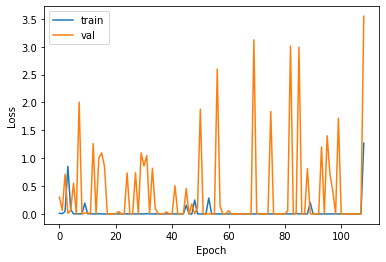

In [40]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

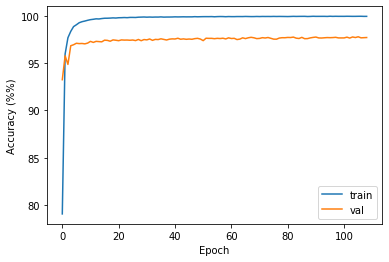

In [41]:
plt.plot(train_accs, label="train")
plt.plot(val_accs, label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%%)")
plt.legend()

In [42]:
np.max(train_accs), np.max(val_accs)

(99.94798890429958, 97.78028910216405)

## Save the model

In [27]:
%%javascript
IPython.notebook.kernel.execute(`notebook_name = '${window.document.getElementById("notebook_name").innerHTML}'`);


<IPython.core.display.Javascript object>

In [63]:
todays_date = datetime.today().strftime('%Y%m%d')
torch.save(model.state_dict(), f"saved_models/{notebook_name}.{todays_date}.pt")

In [16]:
model_file = "/ssd1/home/kdorosch/code/punchcard-tagger/v4/molbit_classification/saved_models/molbit_classification_v4_0_1.20190827.pt"
model = CNN()
model.load_state_dict(torch.load(model_file))
model.eval()
model.cuda()

CNN(
  (conv1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(15,), stride=(1,))
    (1): ReLU()
    (2): AvgPool1d(kernel_size=(6,), stride=(6,), padding=(0,))
  )
  (conv1_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(8,), stride=(1,))
    (1): ReLU()
    (2): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
  )
  (conv2_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Sequential(
    (0): Conv1d(128, 256, kernel_size=(6,), stride=(1,))
    (1): ReLU()
    (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (conv3_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Sequential(
    (0): Conv1d(256, 512, kernel_size=(4,), stride=(1,))
    (1): ReLU()
    (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (conv4_bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, af

## Load the model

In [17]:
model_file = "/ssd1/home/kdorosch/code/punchcard-tagger/v4/molbit_classification/saved_models/molbit_classification_v4_0_1.20190827.pt"

In [18]:
model = CNN()
model.load_state_dict(torch.load(model_file))
model.cuda()
model.eval()


CNN(
  (conv1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(15,), stride=(1,))
    (1): ReLU()
    (2): AvgPool1d(kernel_size=(6,), stride=(6,), padding=(0,))
  )
  (conv1_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(8,), stride=(1,))
    (1): ReLU()
    (2): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
  )
  (conv2_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Sequential(
    (0): Conv1d(128, 256, kernel_size=(6,), stride=(1,))
    (1): ReLU()
    (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (conv3_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Sequential(
    (0): Conv1d(256, 512, kernel_size=(4,), stride=(1,))
    (1): ReLU()
    (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (conv4_bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, af

# Evaluate error

In [19]:
from sklearn.metrics import confusion_matrix

In [25]:
val_loader_params = {"batch_size": 500,
          "shuffle": False,
          "num_workers": 30}
validation_generator = DataLoader(md, sampler=val_sampler, **val_loader_params)

In [26]:
y_pred_all = []
y_true_all = []
for i, (local_batch, local_labels) in enumerate(validation_generator):
#     print(i)
#     print(local_labels.shape)
    # Transfer to GPU
    local_batch = local_batch.to(device)
    local_labels = local_labels.to(device)
    y_pred_val = model(local_batch).to(dtype=torch.float64)
    local_labels = local_labels.to(dtype=torch.long)
    
    t, u = torch.max(y_pred_val, dim=1)
    y_pred_molbits = [int(x) for x in u]
    y_true_molbits = [int(x) for x in local_labels.cpu()]

    y_pred_all.extend(y_pred_molbits)
    y_true_all.extend(y_true_molbits)

In [27]:
np.sum([x == y for x, y in zip(y_true_all, y_pred_all)]), len(y_true_all)

(1290, 118574)

In [28]:
1. * np.sum([x == y for x, y in zip(y_true_all, y_pred_all)]) / len(y_true_all)

0.010879282136050062

In [29]:
l, c = np.unique(y_true_all, return_counts=True)

In [30]:
cm = confusion_matrix(y_true_all, y_pred_all)

NameError: name 'notebook_name' is not defined

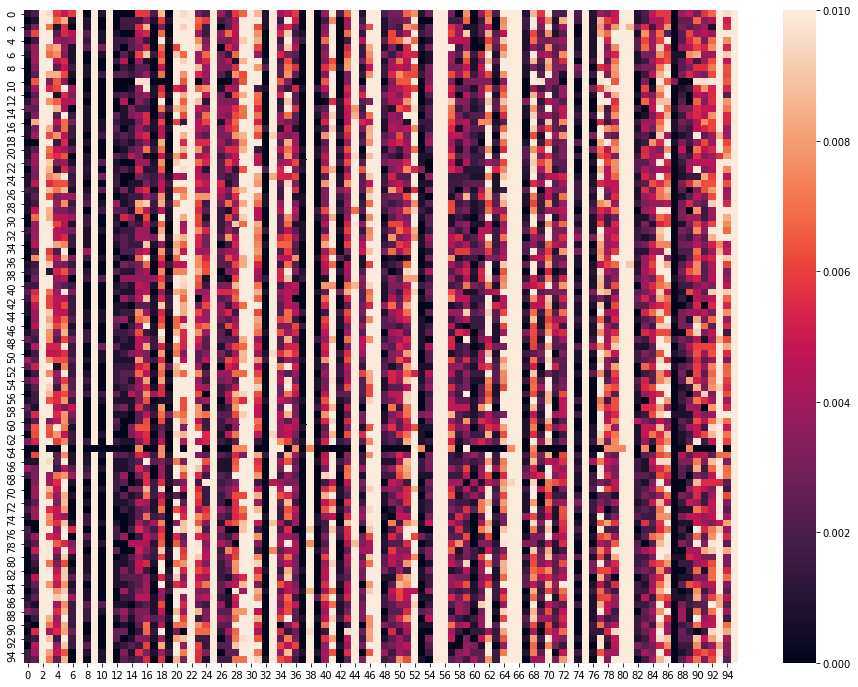

In [31]:
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(cm / c[:, np.newaxis], vmin=0, vmax=0.01)#, vmax=1)
c
plt.savefig(f"/ssd1/home/kdorosch/code/punchcard-tagger/v4/plots/by_model/{notebook_name}_cm_validation.svg")

In [ ]:
from scipy.stats import pearsonr

norm_cm = cm / c[:, np.newaxis]
plt.scatter(c, np.diag(norm_cm))
plt.xlabel("#/ validation examples")
plt.ylabel("Accuracy")
pearsonr(c, np.diag(norm_cm))


# Make predictions on full set

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
loader_params = {"batch_size": 300,
          "shuffle": True,
          "num_workers": 30}
data_generator = DataLoader(md, **loader_params)

In [ ]:
len(y_pred_all)

In [ ]:
np.unique(md.labels, return_counts=True)

In [ ]:
np.unique(y_true_all)

In [ ]:
y_pred_all = []
y_true_all = []
for i, (local_batch, local_labels) in enumerate(data_generator):
#     print(i)
#     print(local_labels.shape)
    # Transfer to GPU
    local_batch = local_batch.to(device)
#     local_labels = local_labels.to(device)
    y_pred_val = model(local_batch).to(dtype=torch.float64)
#     local_labels = local_labels.to(dtype=torch.long)
    
    t, u = torch.max(y_pred_val, dim=1)
    y_pred_molbits = [int(x) for x in u]
    y_true_molbits = [int(x) for x in local_labels.cpu()]

    y_pred_all.extend(y_pred_molbits)
    y_true_all.extend(y_true_molbits)

In [ ]:
np.sum([x == y for x, y in zip(y_true_all, y_pred_all)]), len(y_true_all)

In [ ]:
1. * np.sum([x == y for x, y in zip(y_true_all, y_pred_all)]) / len(y_true_all)

In [ ]:
l, c = np.unique(y_true_all, return_counts=True)

In [ ]:
cm = confusion_matrix(y_true_all, y_pred_all)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(cm / c[:, np.newaxis], vmin=0, vmax=0.01)#, vmax=1)
ax.set_title("Confusion matrix for model v4_0_1\npredictions across all training data")
ax.set_xlabel("True (by sequence)")
ax.set_ylabel("Predicted (using model on squiggles)")
plt.savefig(f"/ssd1/home/kdorosch/code/punchcard-tagger/v4/plots/by_model/{notebook_name}_cm_alltrain.svg")

In [ ]:
from scipy.stats import pearsonr

norm_cm = cm / c[:, np.newaxis]
plt.scatter(c, np.diag(norm_cm))
plt.xlabel("#/ training examples")
plt.ylabel("Accuracy")
pearsonr(c, np.diag(norm_cm))